#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as st
import pandas as pd

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/refs/heads/master/donkeys.csv")
x = df["Weight"]
N = np.size(x)

**Mean**

In [26]:
(1,) + (3,) + (5,)

(1, 3, 5)

In [30]:
def bootstrap(T, data, R = 1_000, conflevel = 0.95, **kwargs):
    shp = np.shape(T(data, **kwargs))
    rng = np.random.default_rng()
    Ts = np.zeros((R,) + shp)
    N = np.shape(data)[0]
    a = (1 - conflevel) / 2
    for r in range(R):
        idx = rng.integers(N, size = N)   
        Ts[r] = T(data[idx], **kwargs)
    return np.quantile(Ts, [a, 1 - a], axis = 0)    

In [31]:
bootstrap(np.mean, x)

array([149.80675551, 154.35491728])

In [5]:
bootstrap(np.median, x)

array([152., 158.])

In [6]:
bootstrap(np.std, x)

array([24.52093543, 28.42205867])

In [7]:
bootstrap(lambda z: np.sqrt(np.var(z)), x, conflevel = 0.98)

array([24.20485749, 28.84863963])

**Linear regression prediction**

In [8]:
def ll_regression(theta, data):
    x = data["x"]
    y = data["y"]
    b0 = theta[0]
    b1 = theta[1]
    return np.sum( (y - (b0 + b1 * x)) ** 2)

In [9]:
def ll_grad(theta, data):
    x = data["x"]
    y = data["y"]
    b0 = theta[0]
    b1 = theta[1]
    lm = b0 + b1 * x
    db0 = np.sum(y - lm)
    db1 = np.sum( x * (y - lm) )
    return -2 * np.array([db0, db1])

In [10]:
rng = np.random.default_rng()
init = rng.normal(size = 2)
d = {
    "x": df["Height"],
    "y": df["Weight"]
}
o = minimize(ll_regression, init, jac = ll_grad, args = (d,))

In [11]:
o.x

array([-309.30049353,    4.55262576])

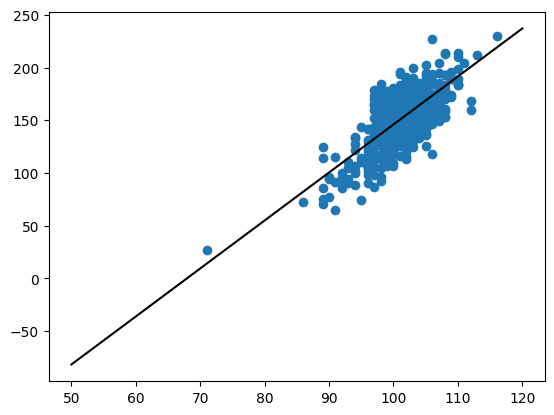

In [12]:
plt.scatter(df["Height"], df["Weight"])
y0 = np.sum(o.x * np.array([1, 50]))
y1 = np.sum(o.x * np.array([1, 120]))
plt.plot(np.array([50, 120]), np.array([y0, y1]), color = "black");

In [13]:
# work in progress; right idea, but needed new
# 1. function T
# 2. data structure
R = 1_000
def bootstrap2(T, data, R = 1_000, conflevel = 0.95):
    ws = np.zeros(R)
    rng = np.random.default_rng()
    for r in range(R):
        init = rng.normal(size = 2)
        idx = rng.integers(N, size = N)
        d = {
            "x": df["Height"][idx],
            "y": df["Weight"][idx]
        }
        o = minimize(ll_regression, init, jac = ll_grad, args = (d,))
        ws[r] = np.sum(o.x * np.array([1, 80]))
    return np.quantile(ws, [0.025, 0.975])

In [14]:
np.sum(o.x * np.array([1, 80]))

54.909567021646296

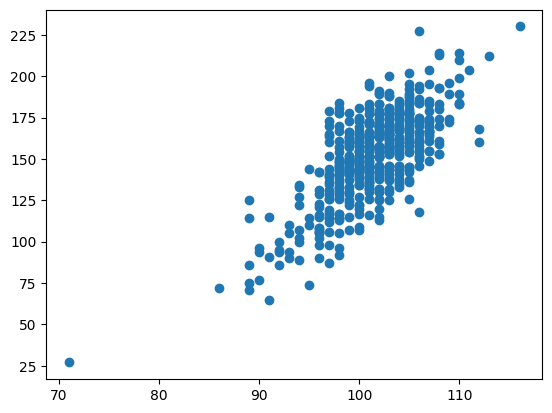

In [15]:
# leaving this here so we can reproduce it
plt.scatter(df["Height"], df["Weight"])
for r in range(R):
    y0 = np.sum(coefs[r] * np.array([1, 50]))
    y1 = np.sum(coefs[r] * np.array([1, 120]))
    plt.plot(np.array([50, 120]), np.array([y0, y1]), color = "black", alpha = 0.01);

In [ ]:
a = np.array([[1,6], [2, 7], [3, 8], [4, 9], [5, 10]])
a

In [ ]:
a[[2, 1]]

In [ ]:
a[1: , 1]

In [ ]:
a[2:4, 1]

In [ ]:
np.sum(a, axis = 0) # collapse 0th axis, left with 2 columns

In [ ]:
np.sum(a, axis = 1) # collapse 1st axis, left with 5 rows

In [16]:
N = np.shape(df)[0]

In [17]:
data = np.c_[df["Weight"], np.ones(N), df["Height"]]

In [18]:
def ll_regression(theta, data):
    X = data[:, 1:]
    y = data[:, 0]
    lm = np.sum(X * theta, axis = 1)
    return np.sum( (y - lm) ** 2 )
    
def ll_grad(theta, data):
    X = data[:, 1:]
    height = X[:, 1]
    y = data[:, 0]
    lm = np.sum(X * theta, axis = 1)
    db0 = np.sum(y - lm)
    db1 = np.sum( height * (y - lm) )
    return -2 * np.array([db0, db1])

In [23]:
def ll_regression_prediction(data, **kwargs):
    rng = np.random.default_rng()
    init = rng.normal(size = np.shape(data[:, 1:])[1])
    o = minimize(ll_regression, init, jac = ll_grad, args = (data,))
    return np.sum(o.x * np.array(kwargs["xnew"]))

In [32]:
bootstrap(ll_regression_prediction, data, xnew = [1, 80])

array([46.64412514, 63.03909406])